# Alogrtym genetyczny wyszukujący wektor wejściowy do StyleGAN3, który reprezentuje rzeczywiste dane termograficzne

### Zaimportowanie bibliotek/framework'ów

In [1]:
from array import array
from plistlib import load
import sys
import os
import time
import torch
import matplotlib.pyplot as plt
import numpy as np
import torchvision as tvision
from torchmetrics.functional import pearson_corrcoef
from PIL import Image
from math import exp
import cv2
import pandas as pd
sys.path.append('D:\Studia\Praca inzynierska\stylegan3-main\stylegan3-main')    
from torch_utils import persistence
from IPython.display import clear_output

### Zaimportowanie wytrenowanej sieci neuronowej

In [2]:
with open('network-snapshot-000050.pkl', 'rb') as f: 
    G = persistence.pickle.load(f)['G_ema'].cuda()

### Wygenerowanie pierwszego obrazu

In [4]:
z=torch.load('tensor.pt') 
c = None   # class labels (not used in this example)               
img = G(z, c)

Setting up PyTorch plugin "bias_act_plugin"... Done.
Setting up PyTorch plugin "filtered_lrelu_plugin"... Done.


### Import obrazu do odtworzenia i wyświetlenie go

In [6]:
img_best=torch.load('tensor_img.pt') #'/content/drive/MyDrive/Colab Notebooks/tensor_img.pt'
print(z.size())
image = np.clip(img_target[0].permute(1,2,0).cpu(), 0, 1)  #converting tensor to right form for displaying image
plt.imshow(image)

### Funkcje odpowiedzialne za ocenę podobieństwa obrazów

In [60]:
def minmax_normalization(val, old_min, old_max, new_min=0, new_max=1):
    return( ( (val - old_min) / (old_max - old_min) ) * (new_max - new_min) + new_min) 

def torchIMG_to_np(img): 
    #input: pyTorch image tensor - float32 - RGB
    #output: numpy matrix - uint8 
    img=tvision.transforms.functional.rgb_to_grayscale(img,1)
    img = img.cpu().numpy()
    mn = img.min()
    mx = img.max()
    mx -= mn
    img = ((img - mn)/mx) * 255
    
    return img[0].astype(np.uint8)

def weighted_mean(diff):
    w,h = diff.shape
    nominator = 0
    denominator = 0
    for x in range(w):
        for y in range(h):
            nominator += (diff[x,y].item())**5
            denominator += diff[x,y].item()**4
    return (nominator/denominator)

def subtract_comp(img1, img2):
    img1 = torchIMG_to_np(img1) 
    img2 = torchIMG_to_np(img2) 
    diff = cv2.subtract(img1, img2) + cv2.subtract(img2, img1)
    return diff

def pearson(img_target,img_to_compare):
    img_tc=tvision.transforms.functional.rgb_to_grayscale(img_to_compare,1)
    img_tg=tvision.transforms.functional.rgb_to_grayscale(img_target,1)
    return pearson_corrcoef(img_tc[0],img_tg[0]).cuda()

def weighted_mean_Pearson(Perason_result_matrix):
    nominator = 0
    denominator = 0
    for i in Perason_result_matrix:

        nominator += (minmax_normalization(i.item(),0,1,0,1000))**5
        denominator += (minmax_normalization(i.item(),0,1,0,1000))**4
    return 1-minmax_normalization((nominator/denominator),0,1000,0,1)
    
def criterion(img_target,img_to_compare):
    pearson_result = pearson(img_target,img_to_compare[0])
    subtract_result = subtract_comp(img_target,img_to_compare[0])
    
    Dmean = minmax_normalization(subtract_result.mean(),0,255,0,100)
    DmeanW = minmax_normalization(weighted_mean(subtract_result),0,255,0,100)
    Dmax = minmax_normalization(subtract_result.max(),0,255,0,100)
    
    Pmean = minmax_normalization(1-torch.mean(pearson_result).item(),0,1,0,100)
    PmeanW = minmax_normalization(weighted_mean_Pearson(pearson_result),0,1,0,100)
    Pmax = minmax_normalization(1-torch.min(pearson_result).item(),0,1,0,100)
    
    return minmax_normalization((DmeanW + Pmax + Dmax),0,300,0,100)  #

#criterion(img_target,img)

### Ustawienie parametrów zmiennego kroku

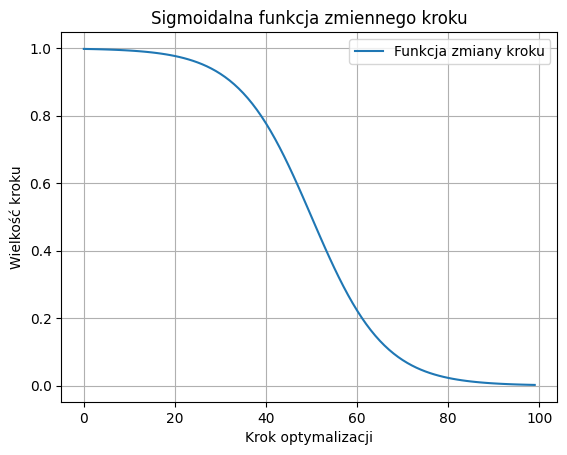

In [72]:
initial_step = 1
epoch_max = 100
P1 = 2
P2 = 8
current_step = []

for epoch in range(epoch_max):  
    current_step.append(initial_step * (1 / (1 + exp((epoch - (epoch_max/P1)) / P2))))

plt.plot(range(epoch+1),current_step, label="Funkcja zmiany kroku")
plt.grid()
plt.xlabel('Krok optymalizacji')
plt.ylabel('Wielkość kroku')
plt.legend()
plt.title('Sigmoidalna funkcja zmiennego kroku')
plt.show()

### Algorytm genetyczny wyszukjący najlpszą ukrytą reprezentację odtwarzanego obrazu

In [73]:
img_size = img.size()
z_size = z.size()
population_size=3

targets = []

results_images = []
results_current_loss=[]
results_best_loss=[]

for file in range(len([entry for entry in os.listdir('testy') if os.path.isfile(os.path.join('testy', entry))])):
    sample_path='testy/sample-' + str(file) + '.png'
    PIL_image = Image.open(sample_path)
    convert_tensor = tvision.transforms.ToTensor()
    img_target = convert_tensor(PIL_image).cuda()

    
    for runs in range(3):

        loss_best = []
        loss_current = []

        img_best = torch.empty(img_size).cuda()
        z_best = torch.zeros(z_size).cuda()


        current_step = []

        epoch=0
        while epoch<epoch_max or loss_best[-1]==0:

            current_step.append(initial_step * (1 / (1 + exp((epoch - (epoch_max/P1)) / P2)))) 

            print('----------------------------------------------------------------------------------------------')
            print('Image: ',str(file+1),'|| Run: ',str(runs+1),'|| Population: ',(epoch+1),'/',epoch_max)
            print('----------------------------------------------------------------------------------------------')

            for population in range(population_size):    
                modulator = torch.randn(z.size()).cuda()
                modulator = torch.mul(modulator, current_step[epoch]).cuda()
                z_current = torch.add(z_best, modulator).cuda()
                img_current = G(z_current,c)
                loss_current.append(criterion(img_target,img_current)) 


                if (loss_best==[]) or (loss_best[-1] > loss_current[(epoch*population_size + population)]) :
                    loss_best.append(loss_current[(epoch*population_size + population)]) 
                    img_best = img_current    
                    z_best = z_current
                else:
                    loss_best.append(loss_best[-1])

                #print('\t Individual: ',(population+1),'\t ## Current loss [%]: ', round(loss_current[(epoch*population_size + population)], 7),'\t  ## Best loss [%]:', round(loss_best[-1], 7))
            clear_output(wait=True)
            epoch += 1
        
        results_images.append(img_best)
        results_current_loss.append(loss_best)
        results_best_loss.append(loss_current)
        
    targets.append(img_target)

----------------------------------------------------------------------------------------------
Image:  8 || Run:  3 Population:  100 / 100
----------------------------------------------------------------------------------------------


### Wynik optymalizacji

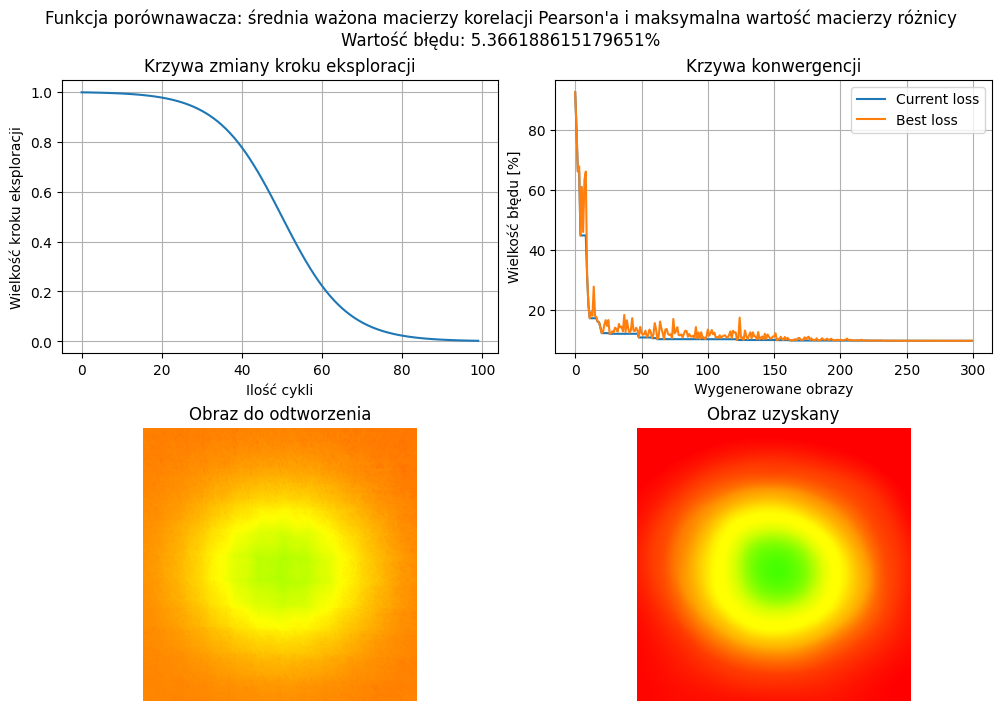

In [189]:
    target = 0 #change this parameter to choose target image
    result = 0 #change this parameter to choose target image [3*target+0|1|2]
    
    fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(7*np.sqrt(2),7), layout="constrained")

    image_target_disp = np.clip(targets[target].permute(1,2,0).cpu(), 0, 1)  #converting tensor to right form for displaying image
    image_best_disp = np.clip(results_images[result][0].permute(1,2,0).cpu(), 0, 1)

    fig.suptitle("Funkcja porównawacza: średnia ważona macierzy korelacji Pearson'a i maksymalna wartość macierzy różnicy\nWartość błędu: "+str(loss_best[-1])+'%')

    ax[0,0].plot(range(epoch),current_step)
    ax[0,0].set_title('Krzywa zmiany kroku eksploracji')
    ax[0,0].set_xlabel('Ilość cykli')
    ax[0,0].set_ylabel('Wielkość kroku eksploracji')
    ax[0,0].grid()

    ax[0,1].plot(range(epoch * population_size), results_current_loss[results], label='Current loss')
    ax[0,1].plot(range(epoch * population_size), results_best_loss[results], label='Best loss')
    ax[0,1].set_xlabel('Wygenerowane obrazy')
    ax[0,1].set_ylabel('Wielkość błędu [%]')
    ax[0,1].legend()
    ax[0,1].grid()
    ax[0,1].set_title('Krzywa konwergencji')

    ax[1,0].imshow(image_target_disp)
    ax[1,0].set_title('Obraz do odtworzenia')
    ax[1,0].axis('off')

    ax[1,1].imshow(image_best_disp)
    ax[1,1].set_title('Obraz uzyskany')
    ax[1,1].axis('off')
    plt.show()

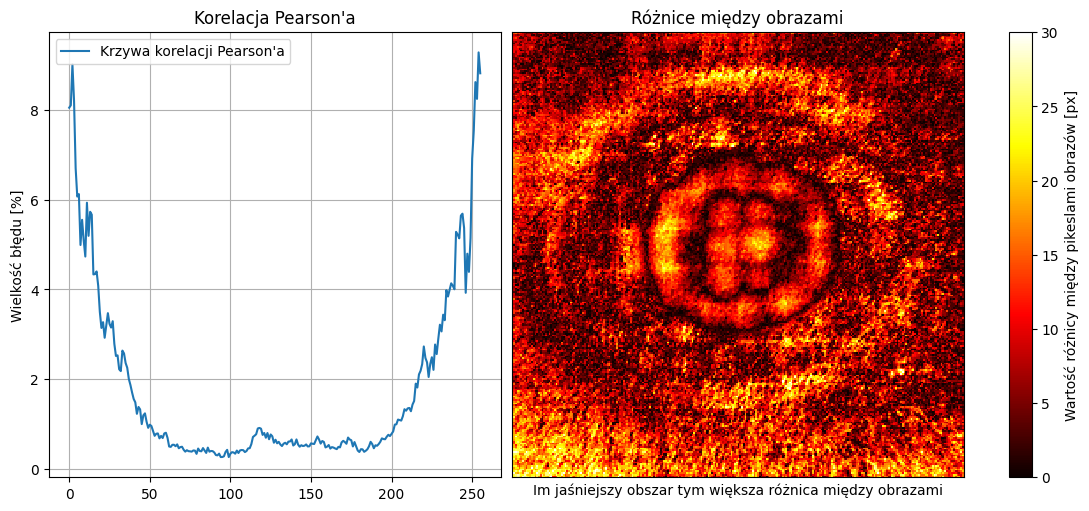

In [190]:
target = 0 #change this parameter to choose target image
result = 0 #change this parameter to choose target image [3*target+0|1|2]

pearson_result = pearson(targets[target], results_images[result][0])
subtract_result = subtract_comp(targets[target], results_images[result][0])

Dmean = minmax_normalization(subtract_result.mean(),0,255,0,100)
DmeanW = minmax_normalization(weighted_mean(subtract_result),0,255,0,100)
Dmax = minmax_normalization(subtract_result.max(),0,255,0,100)

Pmean = minmax_normalization(1-torch.mean(pearson_result).item(),0,1,0,100)
PmeanW = minmax_normalization(weighted_mean_Pearson(pearson_result),0,1,0,100)
Pmax = minmax_normalization(1-torch.min(pearson_result).item(),0,1,0,100)


fig, ax = plt.subplots(1, 2, figsize=(10.8,5), layout="constrained")

ax[0].plot((1-pearson_result.cpu())*100,label='Krzywa korelacji Pearson\'a')
ax[0].set_title("Korelacja Pearson'a")
ax[0].set_ylabel("Wielkość błędu [%]")
ax[0].legend()
ax[0].grid()

c = ax[1].pcolormesh(subtract_result, cmap='hot',vmin=0,vmax=30) 
ax[1].set_title('Różnice między obrazami')
ax[1].set_xlabel('Im jaśniejszy obszar tym większa różnica między obrazami')
# set the limits of the plot to the limits of the data
ax[1].tick_params(left = False, right = False , labelleft = False ,labelbottom = False, bottom = False)
fig.colorbar(c, ax=ax,label="Wartość różnicy między pikeslami obrazów [px]")

plt.show()

### Zestawienie wyników wszystkich wyznczników błędów

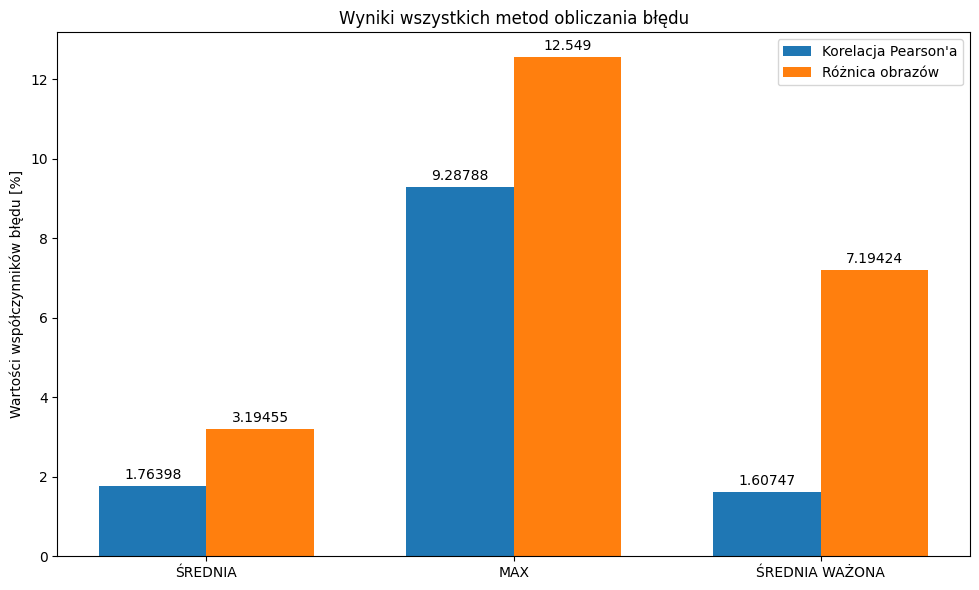

In [191]:
labels = ['ŚREDNIA', 'MAX', 'ŚREDNIA WAŻONA']
results_pearson = [Pmean, Pmax, PmeanW]
results_difference = [Dmean, Dmax, DmeanW]

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots( figsize=(7*np.sqrt(2),6))
rects1 = ax.bar(x - width/2, results_pearson, width, label='Korelacja Pearson\'a')
rects2 = ax.bar(x + width/2, results_difference, width, label='Różnica obrazów')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Wartości współczynników błędu [%]')
ax.set_title('Wyniki wszystkich metod obliczania błędu')
ax.set_xticks(x, labels)
ax.legend()

ax.bar_label(rects1, padding=3)
ax.bar_label(rects2, padding=3)

fig.tight_layout()

plt.show()

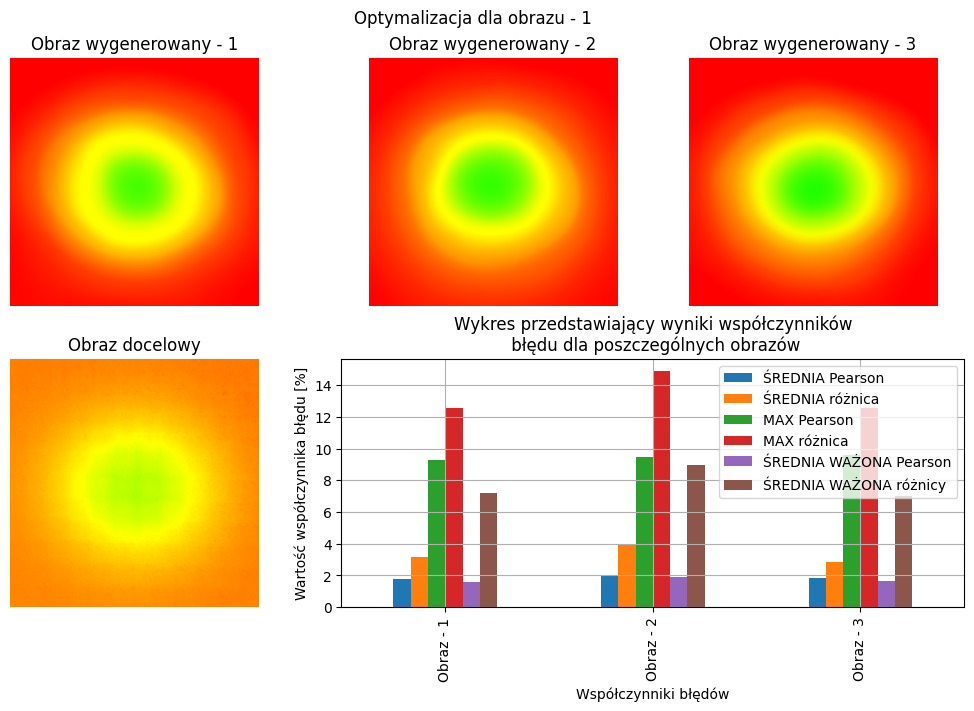

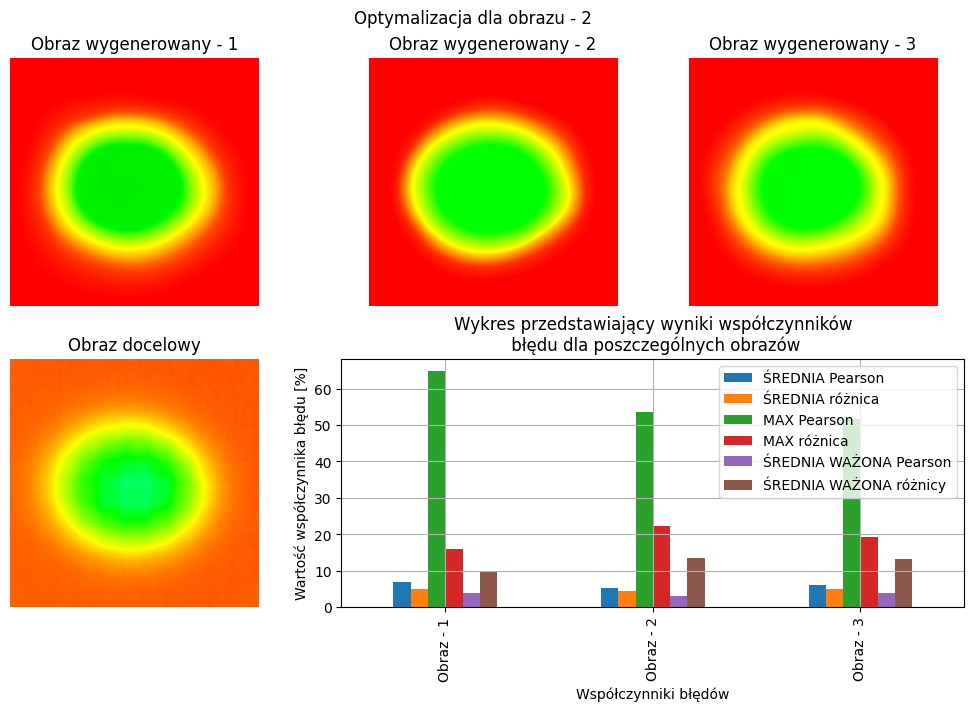

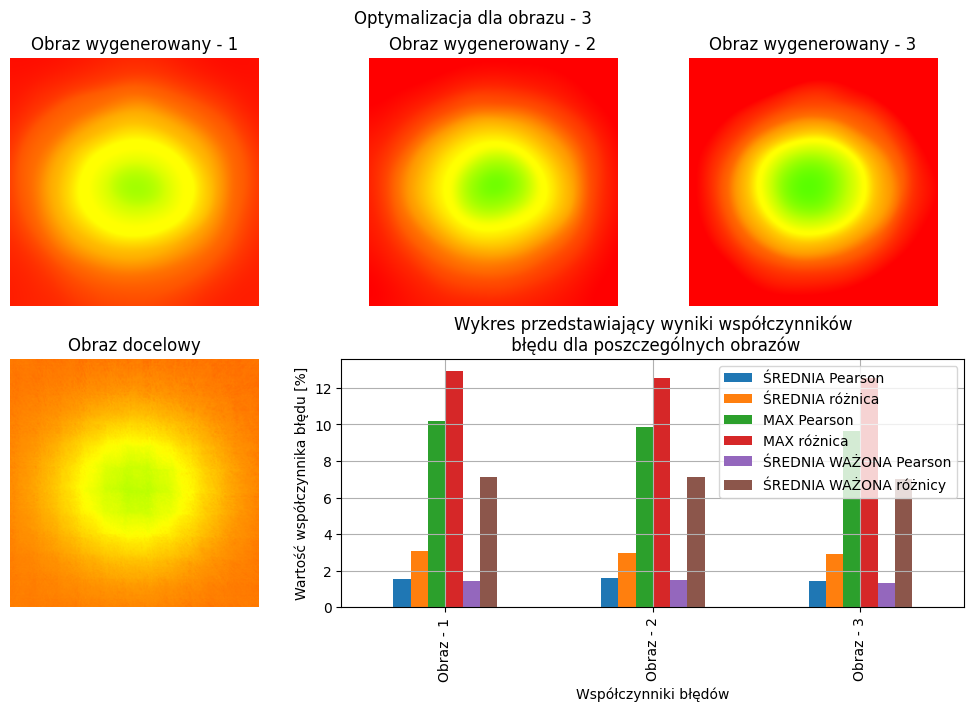

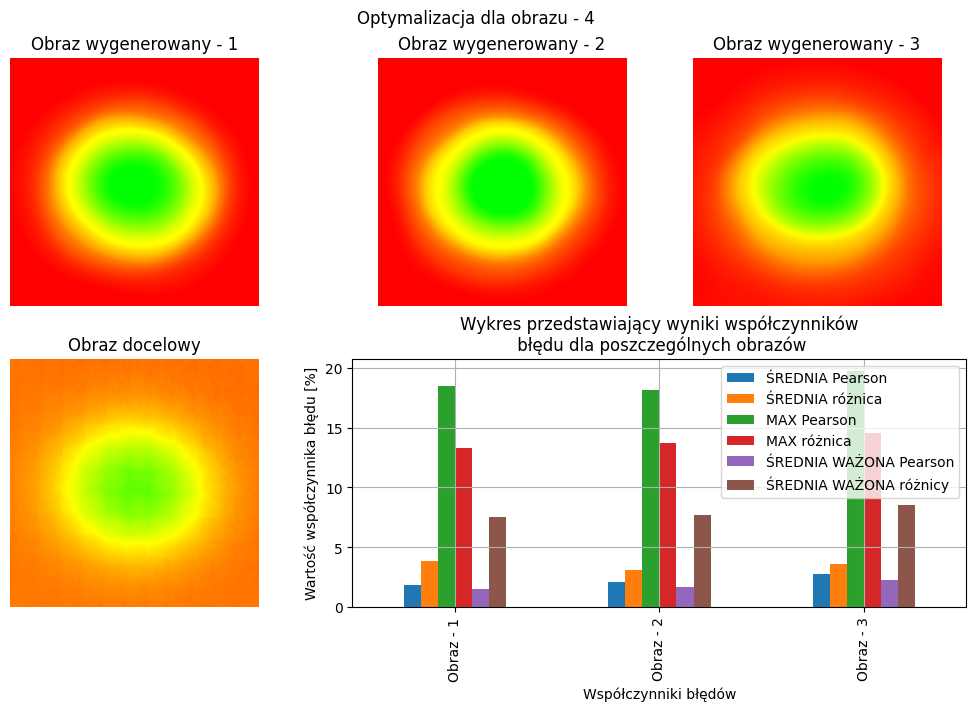

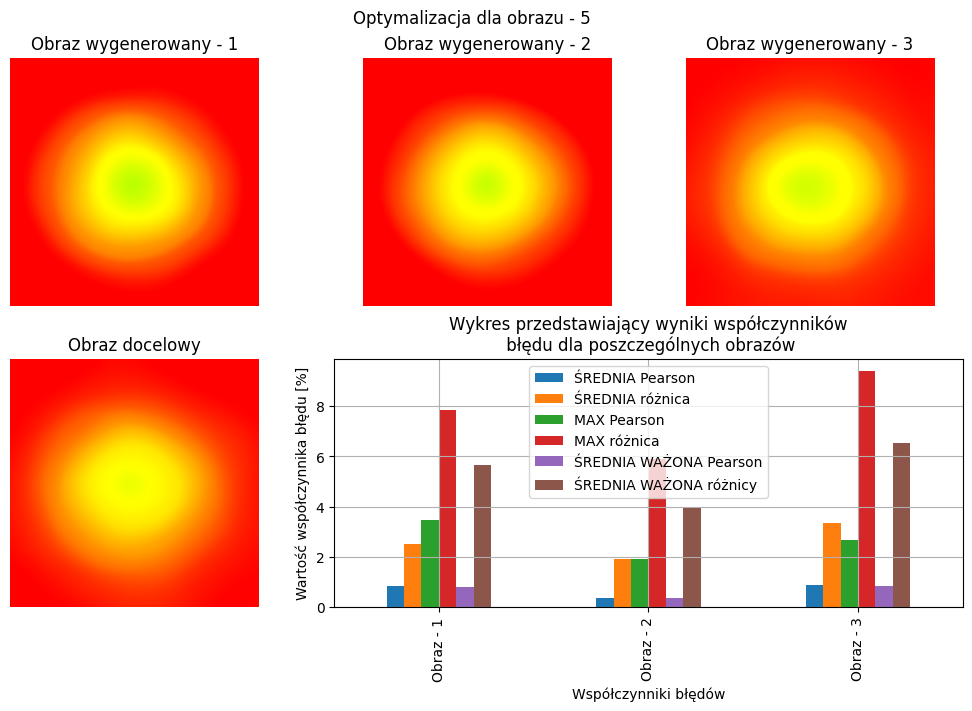

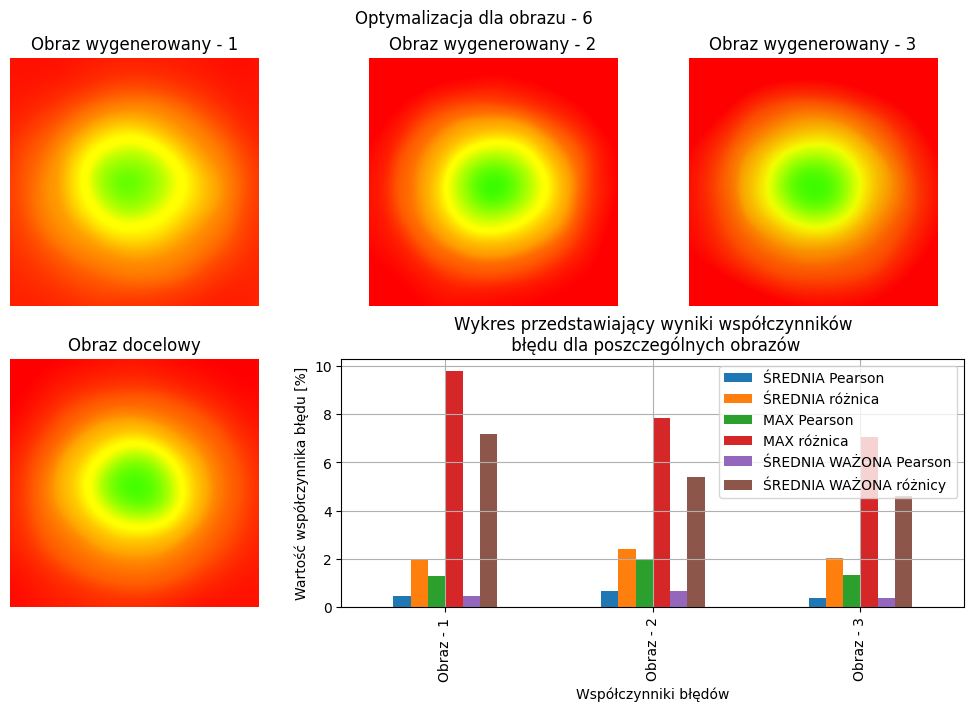

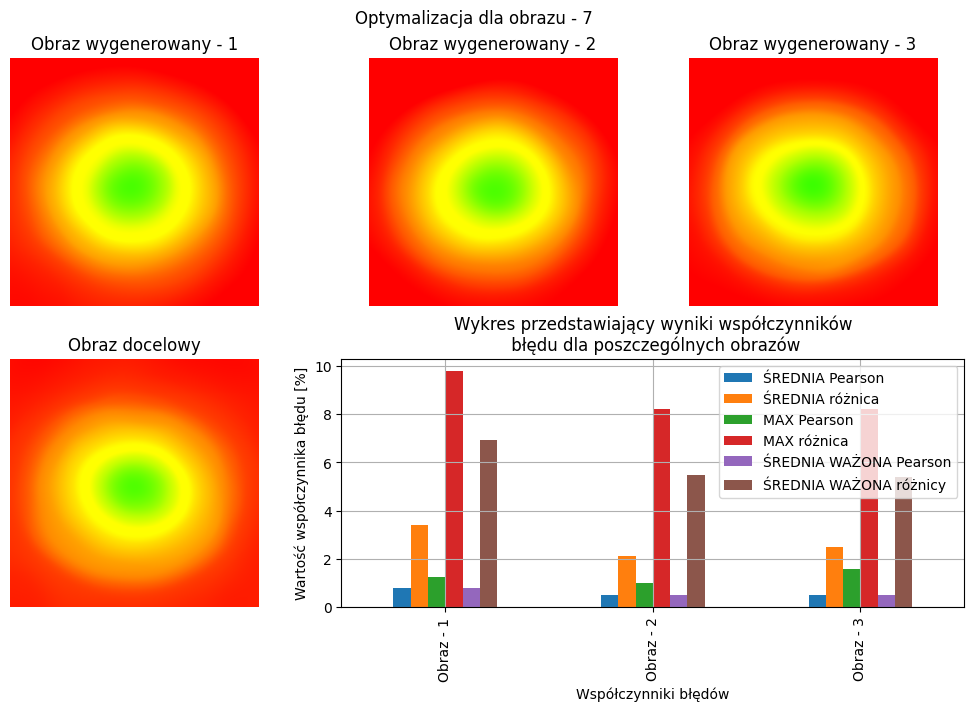

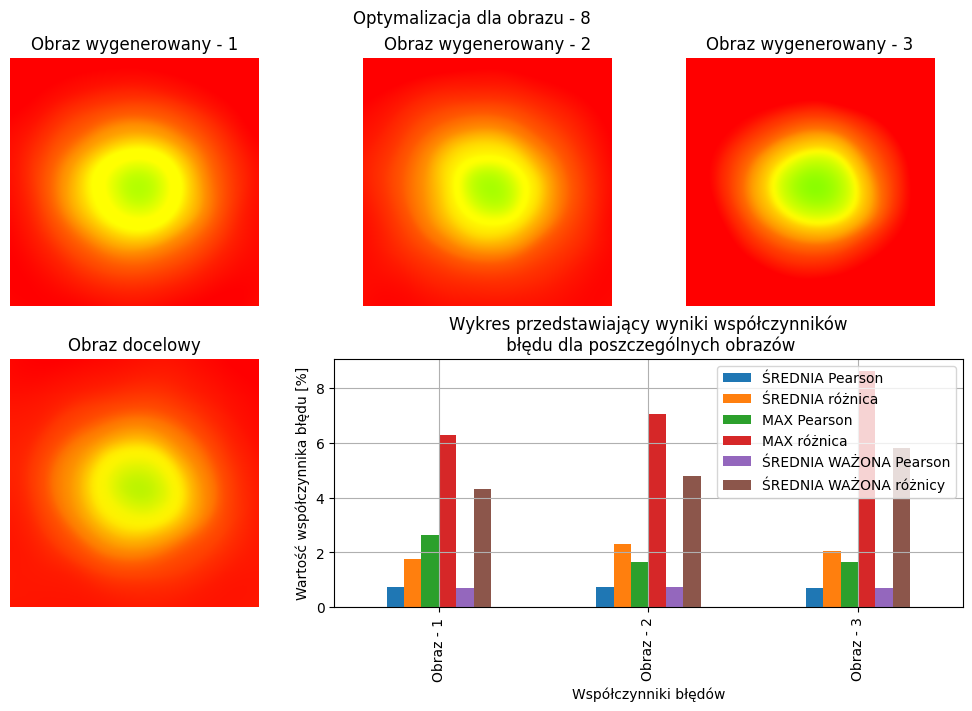

In [188]:
for target in range(len(targets)):
    
    image_target_disp = np.clip(targets[target].permute(1,2,0).cpu(), 0, 1)  #converting tensor to right form for displaying image
    image_best_disp0 = np.clip(results_images[(3*target)][0].permute(1,2,0).cpu(), 0, 1)
    image_best_disp1 = np.clip(results_images[(3*target+1)][0].permute(1,2,0).cpu(), 0, 1)
    image_best_disp2 = np.clip(results_images[(3*target+2)][0].permute(1,2,0).cpu(), 0, 1)

    fig = plt.figure(figsize=(7*np.sqrt(2),7), layout="constrained")
    fig.suptitle('Optymalizacja dla obrazu - '+str(target+1))
    gs = fig.add_gridspec(2,3)

    ax1 = fig.add_subplot(gs[0, 0])
    ax1.imshow(image_best_disp0)
    ax1.set_title('Obraz wygenerowany - 1')
    ax1.axis('off')

    ax2 = fig.add_subplot(gs[0, 1])
    ax2.imshow(image_best_disp1)
    ax2.set_title('Obraz wygenerowany - 2')
    ax2.axis('off')

    ax3 = fig.add_subplot(gs[0, 2])
    ax3.imshow(image_best_disp2)
    ax3.set_title('Obraz wygenerowany - 3')
    ax3.axis('off')

    ax4 = fig.add_subplot(gs[1, 0])
    ax4.imshow(image_target_disp)
    ax4.set_title('Obraz docelowy')
    ax4.axis('off')

    ax5 = fig.add_subplot(gs[1, 1:])

    subtract_result = []
    Dmean = []
    DmeanW = []
    Dmax = []

    pearson_result = []
    Pmean = []
    PmeanW = []
    Pmax = []

    for idx in range(3):
        pearson_result.append( pearson(targets[target],results_images[(3*target+idx)][0]) )
        subtract_result.append( subtract_comp(targets[target],results_images[(3*target+idx)][0]) )

        Dmean.append( minmax_normalization(subtract_result[idx].mean(),0,255,0,100) )
        DmeanW.append( minmax_normalization(weighted_mean(subtract_result[idx]),0,255,0,100) )
        Dmax.append( minmax_normalization(subtract_result[idx].max(),0,255,0,100) )

        Pmean.append( minmax_normalization(1-torch.mean(pearson_result[idx]).item(),0,1,0,100) )
        PmeanW.append( minmax_normalization(weighted_mean_Pearson(pearson_result[idx]),0,1,0,100) )
        Pmax.append( minmax_normalization(1-torch.min(pearson_result[idx]).item(),0,1,0,100) )

        results_pearson.append([Pmean[idx], Pmax[idx], PmeanW[idx]])
        results_difference.append([Dmean[idx], Dmax[idx], DmeanW[idx]])

    x = np.arange(len(labels))  # the label locations
    width = 0.1  # the width of the bars

    df = pd.DataFrame([['Obraz - 1', Pmean[0], Dmean[0], Pmax[0], Dmax[0], PmeanW[0], DmeanW[0]], ['Obraz - 2', Pmean[1], Dmean[1], Pmax[1], Dmax[1], PmeanW[1], DmeanW[1]], ['Obraz - 3', Pmean[2], Dmean[2], Pmax[2], Dmax[2], PmeanW[2], DmeanW[2]]],
                      columns=['Współczynniki błędów', 'ŚREDNIA Pearson', 'ŚREDNIA różnica', 'MAX Pearson', 'MAX różnica','ŚREDNIA WAŻONA Pearson', 'ŚREDNIA WAŻONA różnicy'  ])

    # plot grouped bar chart
    df.plot(ax=ax5,
            x='Współczynniki błędów',
            ylabel="Wartość współczynnika błędu [%]",
            kind='bar',
            grid=True,
            stacked=False)

    ax5.set_title('Wykres przedstawiający wyniki współczynników\n błędu dla poszczególnych obrazów')
    plt.show()